In [1]:
import qforte
from qforte.rtl.rtl import rtl_energy

# Example notebook for using QForte molecule class and using RTQL

# Must use branch rtl_pilot

NOTE: Before running this notebook you will need to have installed Psi4, OpenFermion, and the OpenFermion-Psi4 plugin. There are all avalible via intall through conda-forge and/or pip.

Initialize a QForte molecule, and specify what backend to use. Currently there is only support for using Openfermion-Psi4, but will eventually include direct conections to Psi4 and Forte. First we need to define some input arguments. 

In [2]:
# System factory arguments
system_type = 'molecule'
build_type = 'openfermion'


# Molecule arguments
geometry = [('Be', (0., 0., 0.))]
basis = 'sto-3g'
multiplicity = 1


# Run arguments for backend
run_scf = 1
run_mp2 = 1
run_ccsd = 1
run_fci = 1

We need to initialize an adapter object, wichin in trun is able to ruturn a molecule object.

In [3]:
# Initialize the adapter (specific to backend and system type)
adapter = qforte.system.system_factory(mol_geometry=geometry, basis=basis,
                                       multiplicity=1, description='h4_rtl_test_075')

# Populate the attributes by calling run() with backend run args. we can store the ccsd
# amplitudes 
adapter.run(run_scf=run_scf, run_mp2=run_mp2, run_ccsd=run_ccsd,
                   run_fci=run_fci, store_uccsd_amps=True)


Using standard openfermion hamiltonian ordering!


Get the molecule from the adapter.

In [11]:
Be = adapter.get_molecule()
help(type(Be))

Help on class Molecule in module qforte.system.molecular_info:

class Molecule(builtins.object)
 |  Class for storing moleucular information. Should be instatiated using using
 |  a MolAdapter and populated by calling MolAdapter.run(**kwargs).
 |  
 |  
 |  Atributes
 |  ---------
 |  _mol_geometry : list of tuples
 |      Gives coordinates of each atom in Angstroms. Example format is
 |      geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 1.50))].
 |  
 |  _basis : string
 |      Gives the basis set to be used. Default is 'sto-3g'.
 |  
 |  _multiplicity : int
 |      Gives the targeted spin multiplicity of the molecular system.
 |  
 |  _charge : int
 |      Gives the targeted net charge of the molecular system (controls number of
 |      electrons to be considered).
 |  
 |  _description : optional, string
 |      Recomeded to use to distingush various runs
 |      (for example with differnet bond lengths or geometric configurations),
 |      if populated using a OpenFermionMolAdapt

From the backend, several values are avalible in the molecule for reference.

In [5]:
# Hamiltonian
Hamiltonian = Be.get_hamiltonian()
print('\nQubit Hamiltonian\n', Hamiltonian.str())

# Various energies from psi4 specified in run args
print('\nPsi4 Energies')
print('---------------------------------------------------')
print('hf_energy:                     ', Be.get_hf_energy())
print('mp2_energy:                    ', Be.get_mp2_energy())
print('ccsd_energy:                   ', Be.get_ccsd_energy())
print('fci_energy:                    ', Be.get_fci_energy())


Qubit Hamiltonian
 -9.009402[] +2.243229[Z0] -0.038062[Y0 Z1 Y2] -0.038062[X0 Z1 X2] +2.243229[Z1] -0.038062[Y1 Z2 Y3] -0.038062[X1 Z2 X3] -0.046692[Z2] -0.046692[Z3] -0.148432[Z4] -0.148432[Z5] -0.148432[Z6] -0.148432[Z7] -0.148432[Z8] -0.148432[Z9] +0.568833[Z0 Z1] -0.063333[Y0 Y2] -0.063333[X0 X2] -0.063333[Z0 Y1 Z2 Y3] -0.063333[Z0 X1 Z2 X3] +0.011074[Y0 X1 X2 Y3] -0.011074[X0 X1 Y2 Y3] -0.011074[Y0 Y1 X2 X3] +0.011074[X0 Y1 Y2 X3] +0.003900[Y0 X1 X4 Y5] -0.003900[X0 X1 Y4 Y5] -0.003900[Y0 Y1 X4 X5] +0.003900[X0 Y1 Y4 X5] +0.003900[Y0 X1 X6 Y7] -0.003900[X0 X1 Y6 Y7] -0.003900[Y0 Y1 X6 X7] +0.003900[X0 Y1 Y6 X7] +0.003900[Y0 X1 X8 Y9] -0.003900[X0 X1 Y8 Y9] -0.003900[Y0 Y1 X8 X9] +0.003900[X0 Y1 Y8 X9] +0.131735[Z0 Z2] +0.142809[Z0 Z3] -0.003561[Y0 Z1 Y2 Z3] -0.003561[X0 Z1 X2 Z3] -0.005141[Y0 Z1 Z2 X3 X4 Y5] +0.005141[X0 Z1 Z2 X3 Y4 Y5] +0.005141[Y0 Z1 Z2 Y3 X4 X5] -0.005141[X0 Z1 Z2 Y3 Y4 X5] -0.005141[Y0 Z1 Z2 X3 X6 Y7] +0.005141[X0 Z1 Z2 X3 Y6 Y7] +0.005141[Y0 Z1 Z2 Y3 X6 X7] 

# Real Time Evolution Quantum Lanczos

This method builds a non-orthoganol Krylov space basis to set up a generalized eigenvalue problem $\bar{\mathbf{H}}\mathbf{C} = \mathbf{S}\mathbf{C}\mathbf{\epsilon}$. The basis is generated by unitary real-time evolutions of a reference state. The basis vectors are thus given as $| \Phi_n \rangle = e^{-i n \Delta t \hat{H}}| \Phi_o \rangle$. The elemets of the $\bar{\mathbf{H}}$ and $\mathbf{S}$ matrices can be measured using a quantum computer and the diagonalization performed clasically.   

Here is a sample calculation for a berillium atom which demonstrates energy convergence with increasing number of basis vectors used.

In [6]:
# First we need a reference state (Hartee-Fock usually). 
# In QForte, qubits are aranged as [alpha1, beta1, alpha2, beta2, .... ]
Be_ref = [1,1,1,1,0,0,0,0,0,0]

# Then define parameters, in this case a list of how many N basis vectors to use and the time step.
nbasis_vec = [2,4,6]
dt = 0.25
En_rtl = []

for nbasis in nbasis_vec:


    print('\n------------------------------------------------')
    print('                BEGIN QFORTE RTL')
    print('------------------------------------------------')
    print('    dt:      ', dt)
    print('    nbasis:  ', nbasis)


    RTL_output = rtl_energy(Be, Be_ref, dt, nbasis, print_mats=True, return_all_eigs=True, return_S=True, return_Hbar=True, )
    Ertl = RTL_output[0]
    S = RTL_output[2]
    Hbar = RTL_output[3]

    print('\n---------------------------------------------------------')
    print('hf_energy:                        ', Be.get_hf_energy())
    print('mp2_energy:                       ', Be.get_mp2_energy())
    print('ccsd_energy:                      ', Be.get_ccsd_energy())
    print('fci_energy:                       ', Be.get_fci_energy())
    print('rtl_energy:                       ', Ertl)

    En_rtl.append(Ertl)



------------------------------------------------
                BEGIN QFORTE RTL
------------------------------------------------
    dt:       0.25
    nbasis:   2
------------------------------------------------
     Matricies for Quantum Real-Time Lanczos
------------------------------------------------
Nsteps  :  2
delta t :      0.25

S:

              1-0j  0.607923+0.792977j  
0.607923-0.792977j      1-1.38778e-15j  

Hbar:

      -14.3519-0j      -8.72998-11.3768j  
-8.72998+11.3768j  -14.3502+2.01751e-14j  

RTLanczos (unsorted!) evals from measuring ancilla:
 [-14.3757807 +2.73036001e-13j -13.27199935+1.23537525e-11j]

---------------------------------------------------------
hf_energy:                         -14.35188047620202
mp2_energy:                        -14.376238433837921
ccsd_energy:                       -14.403650748983889
fci_energy:                        -14.403655108067653
rtl_energy:                        -14.375780695810844

----------------------------

# Some Matplotlib imports

In [7]:
%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpl_toolkits.axisartist as AA

mpl.rc('text', usetex = True)
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('mathtext', fontset='stixsans')
mpl.rc('text.latex', preamble=r'\usepackage{cmbright}')

plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = 3.575, 2.65

/Users/renkehuang/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


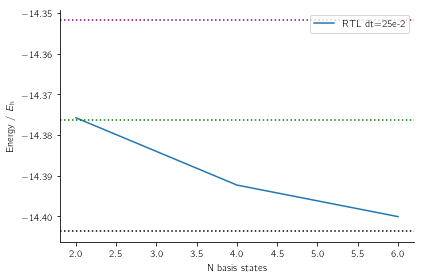

In [8]:
fig, ax = plt.subplots()

ax.plot(nbasis_vec  ,  En_rtl   , color = 'C0'     , label='RTL dt=25e-2', linewidth=1.5)
ax.set(xlabel=r'N basis states')
ax.set(ylabel=r'Energy / \textit{E}$_{\mathrm{h}}$')

plt.axhline(y=Be.get_fci_energy(), linestyle='dotted',color='black')
plt.axhline(y=Be.get_mp2_energy(), linestyle='dotted',color='green')
plt.axhline(y=Be.get_hf_energy(),  linestyle='dotted',color='purple')

plt.tight_layout()
plt.legend()

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
  
plt.show()

In the words of Garnet Chan, "Well, we're better than mean field!"